# **Übung 10a** Programmierung mit Python mit Anwendungen aus dem Maschinellen Lernen

## Aufgabe 1

In dieser Übung sollen Sie auf ein konkretes Problem zur Datendomäne aufmerksam gemacht werden. Diesem Problem begegnen Sie bei fast allen echten Problemen.

**Aufgabe 1.1 (PyTorch)** | Laden Sie ihr Modell aus Übung 10.

In [ ]:
# Download 'custom_mnist.npz'
!gdown 1jweRXd5KgPp-C-Wi9NF27E7JArZhwGpo

In [ ]:
import torch
model = torch.load('YOUR_MODEL.pt')

**Aufgabe 1.2 (PyTorch)** | Der folgende Code testet ihr Modell. Es wird auf verschiedenen Datensätzen getestet. `easy` entspricht dabei den normalen Testdaten aus Übung 10. `medium` und `hard` sind augmentierte MNIST-Daten, die Parameter können dem Code entnommen werden. Des Weiteren gibt es einen `custom` Datensatz, dessen Herkunft eine weiter unten gegebene Webanwendung ist.
```
Beispiel:
easy_acc_top1: 96.30
easy_acc_top3: 99.71

medium_acc_top1: 84.75
medium_acc_top3: 97.39

hard_acc_top1: 53.21
hard_acc_top3: 78.32

custom_top1: 75.54
custom_top3: 90.16
```

Es sollte deutlich werden, dass die Performance auf anderen als dem `easy` Datensatz stark abfällt.

In [ ]:
# Testdaten herunterladen + Transformation anwenden
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from glob import glob

BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tt_easy = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.),
                                ])

tt_medium = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.),
                                transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                transforms.ColorJitter(brightness=0.2, saturation=0.99)
                                ])

tt_hard = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.),
                                transforms.RandomAffine(degrees=15, translate=(0.2,0.2), scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, saturation=0.99)
                                ])

target_transform = transforms.Compose([transforms.Lambda(lambda x:torch.LongTensor([x])),
                                transforms.Lambda(lambda x: (F.one_hot(x, num_classes = 10).float().flatten(),x))
                                ])

class CustomMNIST(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.label = self.data['label']
        self.imgs = self.data['imgs']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):

        img = self.imgs[idx]
        label = self.label[idx]

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, label


custom_data =  np.load('custom_mnist.npz', allow_pickle=True)
custom_loader = {
   f:  DataLoader(CustomMNIST(custom_data[f].item(), transform=tt_easy, target_transform=target_transform), batch_size=BATCH_SIZE, shuffle=False) for f in custom_data.keys()
}

data_loaders = {
    "easy": DataLoader(datasets.MNIST('./data_online', download=True, train=False, transform=tt_easy, target_transform=target_transform), batch_size=BATCH_SIZE, shuffle=False),
    "medium": DataLoader(datasets.MNIST('./data_online', download=True, train=False, transform=tt_medium, target_transform=target_transform), batch_size=BATCH_SIZE, shuffle=False),
    "hard": DataLoader(datasets.MNIST('./data_online', download=True, train=False, transform=tt_hard, target_transform=target_transform), batch_size=BATCH_SIZE, shuffle=False),
    **custom_loader
}

contrib_full_results = {
    "easy": 0.0,
    "medium": 0.0,
    "hard": 0.0,
    **{ k:1.0 for k in data_loaders.keys() if k not in ['easy', 'medium', 'hard']}
}

full_results = {
     k:{'c1': 0, 'c3': 0, 't': 0} for k in data_loaders.keys()
} 

model = model.to(device)
model.eval()

full_correct_test = 0
full_total_test = 0

for k, dl in data_loaders.items():
  for inputs_test, (target_test_oh, target_test) in dl:
    inputs_test = inputs_test.to(device)
    target_test_oh = target_test_oh.to(device)
    target_test = target_test.to(device)
    y_test = model(inputs_test)
    a, target_pred = torch.max(y_test.data, 1)
    b, target_pred_top3 = torch.topk(y_test.data, 3, 1, True, True)

    full_results[k]['c1'] += (target_pred == target_test.flatten()).sum().item()
    full_results[k]['c3'] += ((target_pred_top3[:][:,0] == target_test.flatten()) | (target_pred_top3[:][:,1] == target_test.flatten()) | (target_pred_top3[:][:,2] == target_test.flatten())).sum().item()
    full_results[k]['t'] += target_test.size(0)



  acc_test = 100.0 * full_results[k]['c1'] / full_results[k]['t']
  acc_top3 = 100.0 * full_results[k]['c3'] / full_results[k]['t']

  if 'px' not in k:
    print(f'{k}_acc_top1: {acc_test:.2f}')
    print(f'{k}_acc_top3: {acc_top3:.2f}\n')

c1 = 0
c3 = 0
t = 0
for k in data_loaders.keys():
  factor = contrib_full_results[k]
  c1 += full_results[k]['c1'] * factor
  c3 += full_results[k]['c3'] * factor
  t += full_results[k]['t'] * factor

facc_test = 100.0 * c1 / t
facc_top3 = 100.0 * c3 / t

print(f'custom_top1: {facc_test:.2f}')
print(f'custom_top3: {facc_top3:.2f}')


**Aufgabe 1.3 (PyTorch)** | Durch die Datenmanipulation oder den selbst aufgezeichneten Daten, verändert sich die Domäne der Daten. Auch wenn die Domänen auf den ersten Blick ähnlich erscheinen, sind trainierte Modelle oft so weit angepasst, dass sie keine gute Performance auf der neuen und unbekannten Domäne mehr liefern.


Im folgenden können Sie drei Verfahren testen, um die Generalisierung auf unbekannte Daten zu erhöhen. Diese sind:
- Bessere Architekturen
- Vortrainiertes Modell verwenden + Fine-Tuning
- Unbekannte/Neue Daten sammeln und neu trainieren


Zunächst ist eine kleine interaktive Anwendung gegeben. Wenn Sie die nächste Zelle starten, können Sie auf diese über den in der Ausgabe angegebenen Link zugreifen.

`Beispiel: https://NUMERS-8000-colab.googleusercontent.com/`

Die Website erlaubt Ihnen zu zeichen und den Output des eigenen Modells zu visualisieren.


In [ ]:
# Make the server and content run
!pip install jinja2==3.0.1
!pip install itsdangerous==2.0.1
!pip install flask==0.12.2 

#restart runtime
import os
def restart_runtime():
  os.kill(os.getpid(), 9)

!gdown 1_dBKubiLHGqRnDq5sWc0VAx5gb5TDcNM
!unzip static
!mkdir debug

In [ ]:
import os, sys, json, re
import uuid

import numpy as np
import cv2

from flask import Flask, request
from flask import send_from_directory

from PIL import Image, ImageOps
from io import BytesIO
import base64

from google.colab.output import eval_js

import torch
from torchvision import transforms

SAVE_IMAGES = True

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.), 
                                ])

site_access = eval_js("google.colab.kernel.proxyPort(8000)")

if os.path.exists('/content/static/draw_template.js'):
  with open('/content/static/draw_template.js', 'r') as f:
    data = [l.replace('→TOKEN←', f'{site_access}hook') for l in f.readlines()]
  with open('/content/static/draw.js', 'w') as f:
      f.writelines(data)
  
print(site_access)

def convert_from_image_to_cv2_grey(img: Image) -> np.ndarray:
    return np.array(img)[:,:,3]

def process_image(img, blur_fact, sid, object_class, brush_size, save=True):
  img = img.copy()
  if blur_fact != 0:
    img = cv2.GaussianBlur(img, (blur_fact,blur_fact), cv2.BORDER_DEFAULT)

  img = cv2.resize(img, (28,28))
  if save:
    fn = f'debug/{object_class}_{brush_size}px_gb{blur_fact}_{sid}.png'
    cv2.imwrite(fn, img)
    return fn, img
  else:
    return "", img

app = Flask(__name__, static_folder='/content/static')
@app.route("/", methods=['GET'])
def base_app():
  return send_from_directory("static", "index.html")

# Static files (compiled JS/CSS, etc.)
@app.route("/<path:path>")
def home(path):
    return send_from_directory('static', path)

@app.route('/hook/<int:object_class>/<int:brush_size>', methods=['POST'])
def save_canvas(object_class, brush_size):
    image_data = re.sub('^data:image/.+;base64,', '', request.form['imageBase64'])
    im = Image.open(BytesIO(base64.b64decode(image_data)))

    sid = uuid.uuid4()

    im_cv = convert_from_image_to_cv2_grey(im)

    saved_files, imgs = zip(*[process_image(im_cv, blur, sid, object_class, brush_size, save=SAVE_IMAGES) for blur in [0, 11, 21]])

    
    model_in = transform(imgs[-1])[None,:]
    model_out =  model(model_in)
    model_out = model_out.flatten()


    #res_scores = torch.nn.Softmax(dim=0)(torch.randn(10))
    res_scores = torch.nn.Softmax(dim=0)(model_out)

    res = {
        'success': True,
        'result': {str(i):e.item() for i,e in enumerate(res_scores)},
        'files': [f for f in
                  saved_files if f],
    }
    return json.dumps(res), 200, {'ContentType': 'application/json'}

app.run(host='localhost', port=8000)

**Aufgabe 1.4 (PyTorch)** | Es sind mittlerweile viele Netzwerkarchitekturen bekannt, die einfach trainiert werden und auch ohne Pre-Training gute Ergebnisse erzielen können.

Eine dieser Architekturen ist die ResNet-Architektur. Eine Anpassung von ResNet18 auf MNIST gibt es unter anderem [hier](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb).

Trainieren und testen Sie das Modell auf der Website oder mit dem Code-Block am Anfang der Übung. Nutzen Sie eine GPU Runtime.

In [ ]:
model = None # ResNet18

**Aufgabe 1.5 (PyTorch)** | Verwendung von vortrainierten Netzen. Alle größeren Frameworks, auch PyTorch, stellen eine Auswahl an vortrainierten Netzen zur Verfügung. Das Training dieser Netze erfolgt auf sehr großen und diversen Datensätzen und erzeugt dadurch einen sehr guten und generalisierenden Feature-Detector. Für eigene Probleme muss meist nur der letzte Fully-Connected Layer neu trainiert werden.

Erstellen Sie sich ein ResNet50 und trainieren Sie dies. Nutzen Sie eine GPU Runtime. Testen Sie das Modell auf der Website oder mit dem Code-Block am anfang der Übung.

In [ ]:
model = None #ResNet50

In [ ]:
# Script zum Trainieren
import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

BATCH_SIZE = 128
EPOCHS = 1
LEARNING_RATE = 0.001


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.), 
                                transforms.RandomAffine(degrees=15, translate=(0.2,0.2), scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, saturation=0.99)
                                ])

transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x/255.),
                                ])

target_transform = transforms.Compose([transforms.Lambda(lambda x:torch.LongTensor([x])),
                                transforms.Lambda(lambda x: (F.one_hot(x, num_classes = 10).float().flatten(),x))
                                ])

# Trainingsdaten herunterladen + Transformation anwenden
train_set = datasets.MNIST('./data', download=True, train=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Testdaten herunterladen + Transformation anwenden
test_set = datasets.MNIST('./data', download=True, train=False, transform=transform_test, target_transform=target_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 5
torch.manual_seed(123)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = nn.CrossEntropyLoss()

all_losses = []
progress_bar = tqdm.tqdm(range(EPOCHS), leave=False)

# Epochen durchlaufen
for epoch in progress_bar:
    losses_train = []
    
    total_train = 0
    model.train()
    # Modell trainieren
    for inputs_train, (target_train_oh, target_train) in train_loader:
        inputs_train = inputs_train.to(device)
        target_train_oh = target_train_oh.to(device)
        target_train = target_train.to(device)
        optimizer.zero_grad()
        y_train = model(inputs_train)
        loss = loss_fn(y_train, target_train_oh)

        loss.backward()
        
        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses_train.append(loss.item())
        total_train += target_train.size(0)

    # Modell testen
    with torch.no_grad():
        model.eval()
        correct_test = 0
        total_test = 0
        losses_test = []
        for inputs_test, (target_test_oh, target_test) in test_loader:
          inputs_test = inputs_test.to(device)
          target_test_oh = target_test_oh.to(device)
          target_test = target_test.to(device)
          y_test = model(inputs_test)
          _, target_pred = torch.max(y_test.data, 1)
          total_test += target_test.size(0)
          correct_test += (target_pred == target_test.flatten()).sum().item()
          loss_test = loss_fn(y_test, target_test_oh)

          losses_test.append(loss_test.item())

    epoch_loss = sum(losses_train) / total_train
    epoch_loss_test = sum(losses_test) / total_test
    acc_test = 100.0 * correct_test / total_test
    lr = optimizer.param_groups[-1]['lr']
    scheduler.step(epoch_loss_test)

    all_losses.append([epoch, epoch_loss, epoch_loss_test,acc_test,lr])


# Ergebnisse anzeigen
df_loss = pd.DataFrame(np.array(all_losses), columns=['epoch', 'loss_train', 'loss_test','acc_test','lr'])

fig = px.line(df_loss, x='epoch', y=['loss_train','loss_test'], width=850, height=500, log_y=True)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="loss",
)
fig.show()

fig = px.line(df_loss, x='epoch', y=['acc_test'], width=850, height=500)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="acc",
)
fig.show()

fig = px.line(df_loss, x='epoch', y=['lr'], width=850, height=500, log_y=True)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="learning_rate",
)
fig.show()

In [ ]:
torch.save(model, 'good.pt')

**Aufgabe 1.6 (PyTorch)** | Ergebnisse sollten sich durch die Verwendung von vortrainierten Modellen schon deutlich verbessert haben. Für manche Anwendungsfälle ist dies immer noch nicht ausreichend und Sie müssen auf diesen spezifischen Daten nachtrainieren. Die Website erlaubt, gezeichnete Bilder abzuspeichern, um sie für ein weiteres Training zu verwenden.


Erzeugte Daten können zum Training, aber auch zum Testen verwendet werden.

Folgendes ist anzupassen:
1. `SAVE_IMAGES = True`
2. Durch den Class-Slider lässt das Label des Bildes festlegen
image.png
3. Durch den folgenden Button können Zeichnungen direkt mit verschiedenen Strichstärken abgespeichert werden:
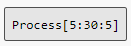 
4. Erzeugte Daten müssen zu einem Datenset zusammengefasst werden. Das nachfolgende Skript kann dabei helfen. Am Anfang dieser Übung wird ein auf gleiche Weise gebauter Datensatz geladen.

In [ ]:
from glob import glob
import cv2
import copy
from tqdm import tqdm

all_files = [(cv2.imread(i, 0), int(i.split('_')[0][-1]), i.split('_')[1], i.split('_')[2]) for i in glob('debug/*.png')]

data = {}
entry = {'imgs': [], 'label': []}


for imgs, label, px, smooth in tqdm(all_files):
  k = f'{px}_{smooth}'
  if k not in data:
    data[k] = copy.deepcopy(entry)
  data[k]['imgs'].append(imgs)
  data[k]['label'].append(label)

for k in tqdm(data.keys()):
  data[k]['imgs'] = np.array(data[k]['imgs'])
  data[k]['label'] = np.array(data[k]['label'])


np.savez_compressed(f'your_custom_data', **data)